<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/exploring_emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.optimize import minimize

! pip install emcee
! pip install corner

import emcee
import corner

# Данные

Подгрузим все данные.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

#lensPlane1=fits.open("maps/IRIS417.fits")[0].data
#lensPlane2=fits.open("maps/IRIS314.fits")[0].data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/IKI/Микролинзирование


Незашумленные кривые блеска:

In [ ]:
filename = 'data/refE5R50M20Ni2m2b5m3Z01_h5.ubv' 
model_curves = pd.read_csv(filename, header=0, delim_whitespace=True)

t1 = np.array(model_curves.time.values)      
lc1 = np.array(model_curves.F160W.values)

t_min = 20
cadence = 70 #test

t1_grid = np.linspace(t_min, np.max(t1), cadence) # зададим сетку, чтобы точно контролировать количество точек и временной интервал
m1 = np.interp(t1_grid, t1, lc1)  # линейная интерполяция кривой lc1 на новую сетку t1_grid

Сдвинем кривую по времени и магнитуде:

In [ ]:
#https://arxiv.org/pdf/1512.05734.pdf - Rodney et al. 2016
#https://arxiv.org/pdf/2007.04106.pdf - Baklanov et al. 2021

dt_true = 9.5

magn_ratio = 1.14

dm_true = -2.5*np.log10(magn_ratio)
print(dm_true)

t2_grid = t1_grid + dt_true # второе изображение
m2 = m1 + dm_true

-0.14226212834118138


Функция для единого оформления графиков:

In [ ]:
from matplotlib import rcParams

def grafik():
  
  rcParams['figure.figsize'] = (7,5)
  plt.title('Кривые блеска SN Refsdal', fontsize=15)
  plt.xlabel('Время (в днях) с момента взрыва сверхновой', fontsize=15)
  plt.ylabel('Блеск', fontsize=15)
  plt.ylim(26, 28.5)
  plt.gca().invert_yaxis()
  plt.legend()
  plt.grid()
  plt.show()

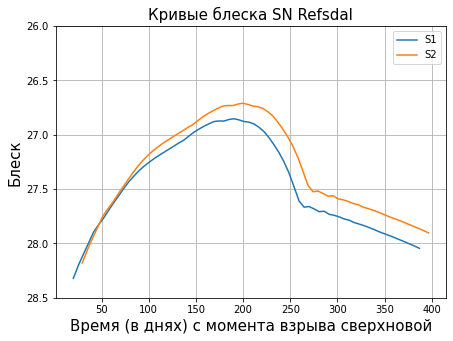

In [ ]:
plt.plot(t1_grid, m1, label="S1")
plt.plot(t2_grid, m2, label="S2")

grafik()

# Добавляем микролинзирование

Добавим шум:

In [ ]:
fluct1 = pd.read_csv('data/micro_data_S1_alot1.csv').to_numpy()
fluct2 = pd.read_csv('data/micro_data_S2_alot1.csv').to_numpy()
length = 70

In [ ]:
pd.DataFrame(fluct1)#.drop([i for i in range(5,3+length-2)], axis=1).drop([i for i in range(3+length+2,3+2*length-2)], axis=1).drop([i for i in range(3+2*length+2,3+3*length-2)], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212
0,7965.0,3799.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.046083,-0.045972,-0.045794,-0.046051,-0.045925,-0.045838,-0.045949,-0.045879,-0.045673,-0.045797,-0.045837,-0.045766,-0.045711,-0.045754,-0.045723,-0.045686,-0.045722,-0.045693,-0.045609,-0.045647,-0.045579,-0.045527,-0.045512,-0.045524,-0.045452,-0.045238,-0.045347,-0.045445,-0.045313,-0.045312,-0.045261,-0.045208,-0.045145,-0.044998,-0.045174,-0.045049,-0.045103,-0.045036,-0.044929,-0.044908
1,837.0,7468.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.089875,-0.089691,-0.089674,-0.089851,-0.090010,-0.089771,-0.090080,-0.090089,-0.090065,-0.090231,-0.090079,-0.090237,-0.090435,-0.090394,-0.090417,-0.090381,-0.090521,-0.090638,-0.090640,-0.090772,-0.090723,-0.090811,-0.090949,-0.091085,-0.091036,-0.091008,-0.091177,-0.091284,-0.091401,-0.091518,-0.091427,-0.091652,-0.091701,-0.091753,-0.091880,-0.092015,-0.092034,-0.092087,-0.092146,-0.092328
2,3239.0,8060.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-1.043366,-1.038644,-1.034587,-1.030549,-1.027205,-1.023487,-1.019783,-1.015754,-1.012446,-1.009548,-1.006435,-1.003456,-1.000170,-0.997385,-0.994786,-0.992095,-0.989602,-0.986984,-0.984672,-0.982041,-0.979778,-0.977861,-0.975474,-0.973533,-0.971190,-0.969147,-0.967330,-0.965371,-0.963386,-0.961537,-0.959736,-0.958083,-0.956320,-0.954772,-0.953092,-0.951591,-0.950005,-0.948621,-0.947231,-0.945873
3,6883.0,9847.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.503306,0.502870,0.503027,0.502889,0.502743,0.503017,0.503077,0.503163,0.503012,0.502773,0.502748,0.502627,0.502675,0.502805,0.502683,0.502814,0.502803,0.502586,0.502480,0.502673,0.502851,0.502620,0.502625,0.502601,0.502551,0.502323,0.502457,0.502441,0.502329,0.502465,0.502295,0.502226,0.502356,0.502377,0.502400,0.502247,0.502171,0.502210,0.502135,0.501977
4,9839.0,7071.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.871819,0.872333,0.871577,0.871760,0.871766,0.872022,0.871977,0.871887,0.871806,0.872148,0.872193,0.872033,0.871767,0.871739,0.871885,0.871983,0.871846,0.871895,0.871824,0.871820,0.871856,0.871844,0.871855,0.871853,0.871765,0.871570,0.871753,0.871754,0.871694,0.871659,0.871699,0.871584,0.871600,0.871673,0.871557,0.871527,0.871566,0.871679,0.871484,0.871457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,8236.0,3925.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.519514,-0.539299,-0.558871,-0.579769,-0.595285,-0.607260,-0.619729,-0.632130,-0.641272,-0.650069,-0.656530,-0.663579,-0.669606,-0.675197,-0.680414,-0.685476,-0.689035,-0.692988,-0.695973,-0.699283,-0.701483,-0.703184,-0.705652,-0.707033,-0.708832,-0.709755,-0.710679,-0.712

In [ ]:
pd.DataFrame(fluct2)#.drop([i for i in range(5,3+length-2)], axis=1).drop([i for i in range(3+length+2,3+2*length-2)], axis=1).drop([i for i in range(3+2*length+2,3+3*length-2)], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212
0,5466.0,197.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,1.440404,1.439879,1.439975,1.436046,1.435967,1.435839,1.435657,1.433988,1.434328,1.434794,1.433928,1.434284,1.432529,1.430423,1.430100,1.429286,1.428334,1.426265,1.425626,1.425084,1.424198,1.423329,1.422602,1.420904,1.418545,1.418029,1.417417,1.415866,1.414294,1.413604,1.411963,1.410458,1.409416,1.407434,1.406655,1.404535,1.402868,1.400782,1.399697,1.398288
1,7083.0,6701.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.966996,-0.965281,-0.963474,-0.962122,-0.960228,-0.958539,-0.957657,-0.956032,-0.955124,-0.954480,-0.953456,-0.953506,-0.952924,-0.953052,-0.953208,-0.953470,-0.954186,-0.954977,-0.956184,-0.957297,-0.958880,-0.960672,-0.962118,-0.964007,-0.966216,-0.968230,-0.970361,-0.972682,-0.974827,-0.977068,-0.979321,-0.981688,-0.983962,-0.986552,-0.989356,-0.992061,-0.995006,-0.998798,-1.002647,-1.007764
2,7869.0,1340.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,1.137156,1.135661,1.137711,1.137186,1.135471,1.136543,1.136346,1.137249,1.137909,1.137021,1.137417,1.137000,1.137220,1.136925,1.137123,1.136852,1.136856,1.136741,1.137034,1.137175,1.136913,1.136687,1.136245,1.135834,1.136603,1.135883,1.135799,1.135292,1.135438,1.135328,1.136269,1.135576,1.135548,1.135767,1.135502,1.135480,1.135078,1.135398,1.135327,1.135281
3,3754.0,2648.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.483359,0.484267,0.484052,0.482910,0.482227,0.483149,0.482092,0.482579,0.482603,0.481699,0.482219,0.482511,0.482843,0.482742,0.482114,0.481915,0.481107,0.472894,0.459810,0.445142,0.434001,0.424561,0.415730,0.406952,0.398939,0.390413,0.383323,0.376696,0.369579,0.363315,0.357698,0.352012,0.347059,0.342501,0.337628,0.334184,0.329710,0.325588,0.322037,0.318203
4,7429.0,7423.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.085308,0.085701,0.085274,0.085188,0.084058,0.084324,0.083952,0.083260,0.082860,0.082786,0.082558,0.081715,0.082041,0.080915,0.080816,0.080352,0.079898,0.079164,0.079378,0.078859,0.078356,0.077264,0.076705,0.076739,0.076077,0.075368,0.074559,0.073960,0.073980,0.073713,0.073111,0.072324,0.071661,0.070490,0.070113,0.069195,0.068645,0.067907,0.067309,0.066823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,8445.0,9511.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.814201,0.813845,0.814623,0.813285,0.814689,0.814149,0.814064,0.814805,0.814614,0.814260,0.813105,0.813386,0.814695,0.814402,0.814264,0.814465,0.814182,0.814558,0.813670,0.814074,0.813868,0.813898,0.814159,0.814421,0.814514,0.814234,0.813735,0.813906,0.813977,0.814234,0.814581,0.813740,0.814359,0.813699,0.813681,0.813730,0.813901,0.813880,0.813954,0.813

In [ ]:
xxs = (fluct1[:, 0], fluct2[:, 0])
yys = (fluct1[:, 1], fluct2[:, 1])
lengths = (fluct1[:,2].astype(int), fluct2[:,2].astype(int))
time_grids = (fluct1[:, 3:3+length], fluct2[:, 3:3+length])
dm_gausss = (fluct1[:, 3+length:3+2*length], fluct2[:, 3+length:3+2*length])
dm_flats = (fluct1[:, 3+2*length:3+3*length], fluct2[:, 3+2*length:3+3*length])

# Рисование - 1 (карты со всеми источниками и все флуктуации)

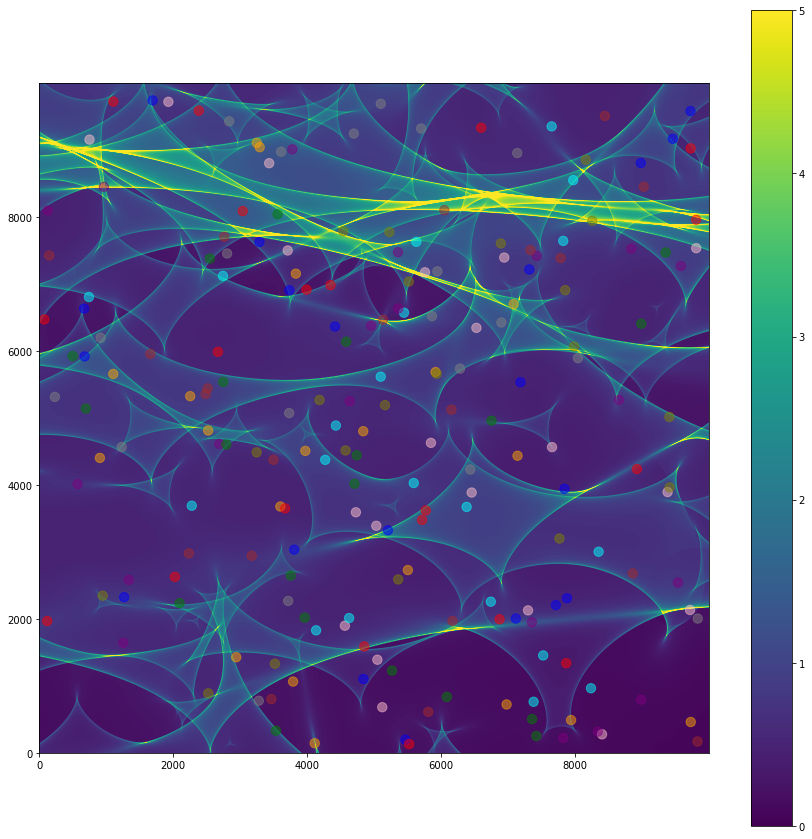

In [ ]:
colors = 20*('blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive','cyan')

#417 - s1 - 346
#314 - s2 - 347

map_number = 347
s=2

image_data = fits.getdata("maps/IRIS"+str(map_number)+".fits")
image = 10**(.4*(image_data-1024)/256.0)

plt.figure(figsize=(15,15))
plt.imshow(image, origin='lower', vmin=0, vmax=5)
plt.colorbar()

for j in range(0, len(fluct1)):

  xx = xxs[s-1][j]
  yy = yys[s-1][j]
  length = lengths[s-1][j]
   
  plt.gca().add_patch( plt.Circle((xx,yy), length, color=colors[j], alpha=0.5) )

#plt.savefig('map_with_circles_S'+str(s)+'.png')
plt.show()

In [49]:
colors = 20*('blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive','cyan')

map_number = 347
s=2

image_data = fits.getdata("maps/IRIS"+str(map_number)+".fits")
image = 10**(.4*(image_data-1024)/256.0)

def f1(number):

  plt.figure(figsize=(10,10))
  plt.imshow(image, origin='lower', vmin=0, vmax=5)
  plt.colorbar(fraction=0.046, pad=0.04)

  for j in range(0, len(fluct1)):
    xx = xxs[s-1][j]
    yy = yys[s-1][j]
    length = lengths[s-1][j]
    plt.gca().add_patch( plt.Circle((xx,yy), length, color=colors[j], alpha=0.5) )

  plt.gca().add_patch( plt.Circle((xxs[s-1][number], yys[s-1][number]), length, color='black', alpha=1) )
  plt.show()

interactive_plot = interactive(f1, number=(0,len(fluct1)-1))
output = interactive_plot.children[-1]
#output.layout.height = '370px'
interactive_plot

interactive(children=(IntSlider(value=99, description='number', max=199), Output()), _dom_classes=('widget-int…

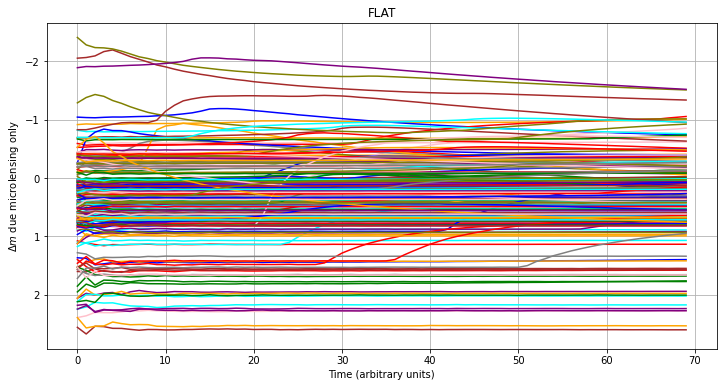

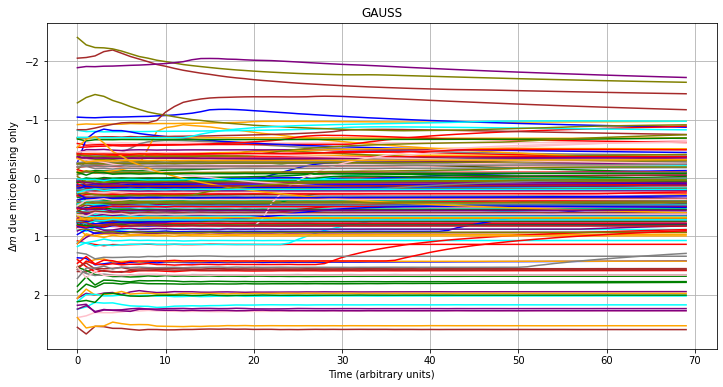

In [ ]:
s=2

plt.figure(figsize=(12,6))

for j in range(0, len(fluct1)):

  time_grid = time_grids[s-1][j]
  dm_gauss = dm_gausss[s-1][j]
  dm_flat = dm_flats[s-1][j]
  
  #print('Number', j, ', center = (', xx, ',', yy,')')
  
  #plt.plot(time_grid, dm_gauss, label='gauss')
  plt.plot(time_grid, dm_flat, label='flat', color=colors[j])
  #plt.axhline(np.median(dm_gauss), color='r', linestyle='--', label='gauss mean')
  #plt.axhline(np.median(dm_flat), color='g', linestyle='--', label='flat mean')

plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
plt.title('FLAT')
#plt.legend()
plt.grid()
plt.savefig('S'+str(s)+'_flat.png')
plt.show()

plt.figure(figsize=(12,6))

for j in range(0, len(fluct2)):

  time_grid = time_grids[s-1][j]
  dm_gauss = dm_gausss[s-1][j]
  dm_flat = dm_flats[s-1][j]
   
  plt.plot(time_grid, dm_gauss, label='gauss', color=colors[j])
  
plt.title('GAUSS')
plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
#plt.legend()
plt.grid()
plt.savefig('S'+str(s)+'_gauss.png')
plt.show()

# Рисование - 2 (отдельная реализация)

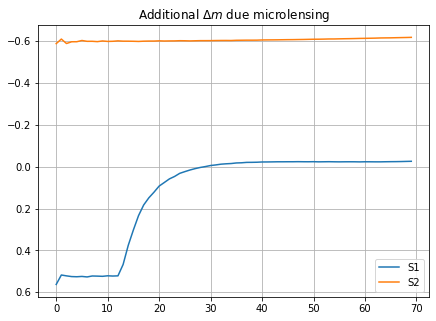

In [ ]:
dm_flat1 = dm_flats[0][7]
dm_flat2 = dm_flats[1][6]

time_grid1 = time_grids[0][7]
time_grid2 = time_grids[1][6]

lc1_noise = m1 + dm_flat1
lc2_noise = m2 + dm_flat2

center1 = ( int(xxs[0][7]), int(yys[0][7]) )
center2 = ( int(xxs[1][6]), int(yys[1][6]) )

plt.plot(time_grid1, dm_flat1, label='S1')
plt.plot(time_grid2, dm_flat2, label='S2')
plt.legend()
plt.title('Additional $\Delta m$ due microlensing')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

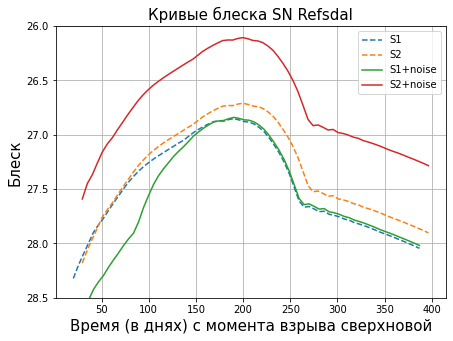

In [ ]:
plt.plot(t1_grid, m1, linestyle='--', label="S1")
plt.plot(t2_grid, m2, linestyle='--', label="S2")

plt.plot(t1_grid, lc1_noise, label="S1+noise")
plt.plot(t2_grid, lc2_noise, label="S2+noise")

#lc2_noise_shifted = np.interp(t1_grid + dt_true, t2_grid, lc2_noise) - dm_true
#plt.plot(t1_grid, lc2_noise_shifted, label="S2 shifted")

grafik()

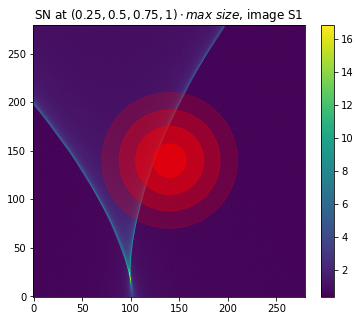

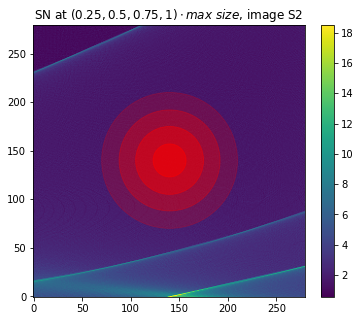

In [ ]:
image_data_S1 = fits.getdata("maps/IRIS346.fits")
image_data_S2 = fits.getdata("maps/IRIS347.fits")

image_S1 = 10**(.4*(image_data_S1-1024)/256.0)
image_S2 = 10**(.4*(image_data_S2-1024)/256.0)

sizes = (0.25, 0.5, 0.75, 1.)
alphas = (1., 0.8, 0.6, 0.4)

plt.imshow(image_S1[center1[1]-2*length:center1[1]+2*length, center1[0]-2*length:center1[0]+2*length], origin='lower')#, vmin=0, vmax = 5)
plt.colorbar(fraction=0.046, pad=0.04)
for i in range(0,4):
  plt.gca().add_patch( plt.Circle((2*length, 2*length), int(sizes[i]*length), color='red', alpha=0.5*alphas[i]) )
plt.title('SN at $(0.25, 0.5, 0.75, 1) \cdot max \ size$, image S1')
plt.show()

plt.imshow(image_S2[center2[1]-2*length:center2[1]+2*length, center2[0]-2*length:center2[0]+2*length], origin='lower')#, vmin=0, vmax = 5)
plt.colorbar(fraction=0.046, pad=0.04)
for i in range(0,4):
  plt.gca().add_patch( plt.Circle((2*length, 2*length), int(sizes[i]*length), color='red', alpha=0.5*alphas[i]) )
plt.title('SN at $(0.25, 0.5, 0.75, 1) \cdot max \ size$, image S2')
plt.show()

#plt.imshow(image_S2[xxs[0][7]], origin='lower', vmin=0, vmax = 5)
#plt.colorbar(fraction=0.046, pad=0.04)
#plt.show()

# emcee

In [ ]:
def model(params, x1, x2, y2):
    dt, dmu = params
    #func = interpolate.interp1d(x2, y2)
    #return func(x1 + dt) - dmu
    return np.interp(x1 + dt, x2, y2) - dmu

def lnlike(params, x1, y1, x2, y2):
    dt, dmu = params
    lnlike = -0.5 * np.sum( ( (y1 - model(params, x1, x2, y2))/1 )**2 )# + np.log(2*np.pi*sigmu**2) )
    return lnlike

def lnprior(params):
    dt, dmu = params
    if (-50. < dt < 100. and -5. < dmu < 5. ):
        return 0.0
    return -np.inf

def lnprob(params, x1, y1, x2, y2):
    lp = lnprior(params)
    if np.isfinite(lp):
      return lp + lnlike(params, x1, y1, x2, y2)
    else:
      return -np.inf

In [ ]:
def best_with_MCMC(dtTrue, dmTrue, lengthofchain, arguments, draw):

  #np.random.seed(45)
  #lnlike1 = lambda *args: -lnlike(*args)
  #initial = np.array([dtTrue, dmTrue]) + 0.01 * np.random.randn(2)
  #optim = minimize(lnlike1, initial, args=arguments)
  
  nwalkers = 100
  initial = [dtTrue, dmTrue]
  ndim = len(initial)
  p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]
  sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = arguments )
  #p0, _, _ = sampler.run_mcmc(p0, 500, progress=True)
  #sampler.reset()
  sampler.run_mcmc(p0, lengthofchain, progress = True)

  samples = sampler.flatchain
  params_best  = samples[np.argmax(sampler.flatlnprobability)]
  randoms = np.random.randint(len(samples), size=50)

  #print("Initial dt = {0:.3f}".format(initial[0]))
  #print("Initial dm = {0:.3f}".format(initial[1]))
  #print("sigmu = {0:.3f}".format(optim.x[2]))

  #print('Best dt = {0:.3f}'.format(s[0]))
  #print('Best dmu = {0:.3f}'.format(s[1])) 
  #print('or best magnification ratio = {0:.3f}'.format(10**(-0.4*s[1])) )

  if draw:
        
    plt.plot(arguments[0], arguments[1], label='S1+noise', color='green')
    plt.plot(arguments[2], arguments[3], label='S2+noise', color='red')
    
    #for params in samples[randoms]:
    #  plt.plot(arguments[0], model(params, arguments[0], arguments[2], arguments[3]), color="b", alpha=0.1)
    
    best_fit_model = model(params_best, arguments[0], arguments[2], arguments[3])
    plt.plot(arguments[0], best_fit_model, color="b", label='Best fit')
    grafik()

    #if False:
    #  fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    #  chain = sampler.get_chain()
    #  labels = ['$\Delta t$', '$\Delta m$', '$\sigma_m$']
    #  for i in range(ndim):
    #      ax = axes[i]
    #      ax.plot(chain[:, :, i], "k", alpha=0.3)
    #      ax.set_xlim(0, len(chain))
    #      ax.set_ylabel(labels[i])
    #      ax.yaxis.set_label_coords(-0.1, 0.5)
    #  axes[-1].set_xlabel("step number")
      #tau = sampler.get_autocorr_time()
      #print(tau)
      #flat_samples = sampler.get_chain()#discard=400, thin=1, flat=False)
      #print(flat_samples.shape)
    
    #  fig = corner.corner(sampler.flatchain, 
    #                      show_titles=True, 
    #                      labels=['$\Delta t$', '$\Delta m$'], 
    #                      truths=[dt_true, dm_true], 
    #                      scale_hist=True, 
    #                      quantiles=[0.16, 0.5, 0.84])

    
  return params_best[0], params_best[1], samples[randoms]

100%|██████████| 500/500 [00:01<00:00, 255.97it/s]


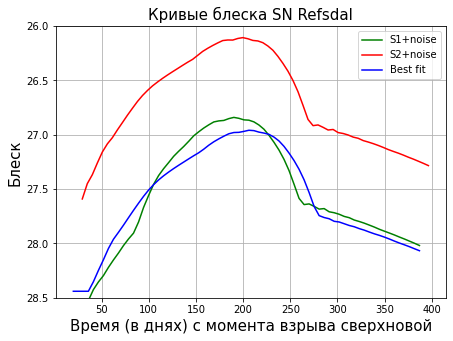

-8.461159984441341 -0.8491214209466704


In [ ]:
best_dt, best_dm, srand = best_with_MCMC(dtTrue=dt_true, 
                                  dmTrue=dm_true, 
                                  lengthofchain=500, 
                                  arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise), 
                                  draw=True)
print(best_dt, best_dm)

In [ ]:
from ipywidgets import interact, interactive

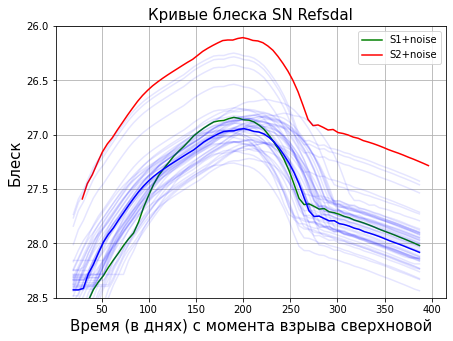

-0.8428757453602973


In [ ]:
arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise)

def f(number):
  s = srand[number]

  plt.plot(arguments[0], arguments[1], label='S1+noise', color='green')
  plt.plot(arguments[2], arguments[3], label='S2+noise', color='red')
  for params in srand:
    plt.plot(arguments[0], model(params, arguments[0], arguments[2], arguments[3]), color="b", alpha=0.1)
  
  plt.plot(t1_grid, model(s, t1_grid, t2_grid, lc2_noise), color="b")
  grafik()
  plt.show()
  print(lnlike(s, t1_grid, lc1_noise, t2_grid, lc2_noise))

interactive_plot = interactive(f, number=(0,50))
output = interactive_plot.children[-1]
output.layout.height = '370px'
interactive_plot

In [ ]:
best_dt = []
best_dm = []

for i in range(0, 50):
  for j in range(0, 50):

    dm_flat1 = dm_flats[0][i]
    dm_flat2 = dm_flats[1][j]

    dm_gauss1 = dm_gausss[0][i]
    dm_gauss2 = dm_gausss[1][j]

    #МЕНЯТЬ ЗДЕСЬ
#-----------------------------------------
    microlensing_noise1 = dm_flat1
    microlensing_noise2 = dm_flat2
#-----------------------------------------
    lc1_noise = m1 + microlensing_noise1
    lc2_noise = m2 + microlensing_noise2

    best_dt1, best_dm1 = best_with_MCMC(dtTrue=dt_true, 
                                    dmTrue=dm_true, 
                                    lengthofchain=500, 
                                    arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise), 
                                    draw = False)
  
    best_dt.append(best_dt1)
    best_dm.append(best_dm1)

pd.DataFrame([best_dt, best_dm]).to_csv('data/delays-200-gerlumph.csv', index=False)

100%|██████████| 500/500 [00:01<00:00, 250.66it/s]


True dt = 9.50
True dm = -0.14
Flat:


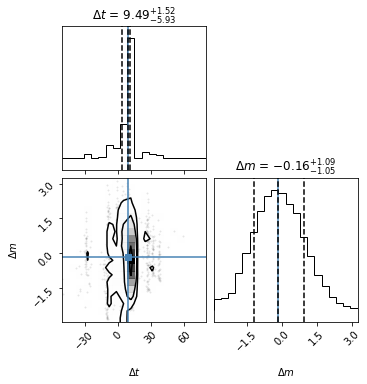

In [ ]:
print("True dt = {0:.2f}".format(dt_true))
print("True dm = {0:.2f}".format(dm_true))
print("Flat:")

rcParams['figure.figsize'] = (10,10)
fig = corner.corner(np.transpose([best_dt, best_dm]), 
                    show_titles=True, 
                    range=((-50., 80.), 1.),
                    labels=['$\Delta t$', '$\Delta m$'], 
                    truths=[dt_true, dm_true], 
                    scale_hist=True, 
                    quantiles=[0.16, 0.5, 0.84])

plt.savefig('histo200-gerlumph.png')

In [ ]:
delays0 = pd.read_csv('data/346and347/delays-200-0.csv').to_numpy()
delays1 = pd.read_csv('data/346and347/delays-200-1.csv').to_numpy()
delays2 = pd.read_csv('data/346and347/delays-200-2.csv').to_numpy()
delays3 = pd.read_csv('data/346and347/delays-200-3.csv').to_numpy()

In [ ]:
all = np.hstack((delays0, delays1, delays2, delays3))

True dt = 9.50
True dm = -0.14
Flat:


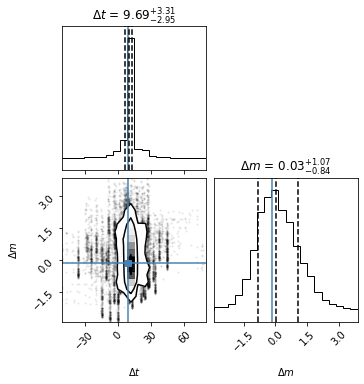

In [ ]:
print("True dt = {0:.2f}".format(dt_true))
print("True dm = {0:.2f}".format(dm_true))
print("Flat:")

rcParams['figure.figsize'] = (10,10)
fig = corner.corner(np.transpose(all), 
                    bins=20,
                    show_titles=True, 
                    range=((-50., 80.), 1.),
                    labels=['$\Delta t$', '$\Delta m$'], 
                    truths=[dt_true, dm_true], 
                    scale_hist=True, 
                    quantiles=[0.16, 0.5, 0.84])

plt.savefig('histo200-all.png')